### Shopify Fall 2022 Data Science Intern Challenge 
#### Name: Praveen Sivashangaran 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

### Read in the data

In [2]:
df_init = pd.read_csv("2019 Winter Data Science Intern Challenge Data Set - Sheet1.csv")

### Exploratory Data Analysis

On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. We want to do some analysis of the average order value (AOV). When we look at orders data over a 30 day window, we naively calculate an AOV of $3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis. 


In [3]:
df_init.info()
# No missing data, 5000 entries, 7 columns 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   order_id        5000 non-null   int64 
 1   shop_id         5000 non-null   int64 
 2   user_id         5000 non-null   int64 
 3   order_amount    5000 non-null   int64 
 4   total_items     5000 non-null   int64 
 5   payment_method  5000 non-null   object
 6   created_at      5000 non-null   object
dtypes: int64(5), object(2)
memory usage: 273.6+ KB


In [4]:
df_init.head(3)

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56


In [5]:
# Convert string to datetime object
df_init['created_at'] = pd.to_datetime(df_init['created_at'])

In [6]:
print(f"Number of sneaker shops: {df_init['shop_id'].nunique()}")
print(f"Median Order value: ${df_init['order_amount'].median()}")
print(f"Average Order value (AOV): ${round(df_init['order_amount'].mean(),2)}")
print(f"Skewness of order_amount feature: {round(df_init['order_amount'].skew(),2)}")
print(f"Timespan of dataset in days: {(df_init['created_at'].max() - df_init['created_at'].min()).days}")

Number of sneaker shops: 100
Median Order value: $284.0
Average Order value (AOV): $3145.13
Skewness of order_amount feature: 16.68
Timespan of dataset in days: 29


**Inference**: 
- Seeing the significant difference between the median and the mean of the order_amount feature, it is clear that the order_amount data is skewed. 
- After computing the skewness of the order_amount feature, it is clear that the order_amount feature is heavily right skewed. 
- The mean is senstive to extreme values or outliers, and the mean is closer to the tail in a skewed distribution, which explains the significantly high calculated AOV. 
- Consequently, the median is better suited for skewed distributions as it is much more robust.

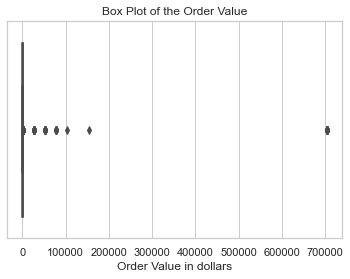

In [7]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=df_init['order_amount'])
ax.set_title("Box Plot of the Order Value")
ax.set_xlabel("Order Value in dollars")
plt.show()

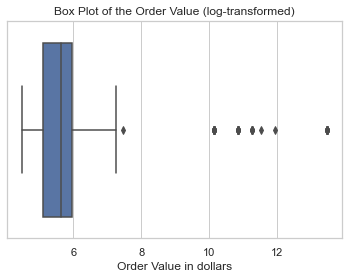

In [8]:
ax = sns.boxplot(x=np.log(df_init['order_amount']))
ax.set_title("Box Plot of the Order Value (log-transformed)")
ax.set_xlabel("Order Value in dollars")
plt.show()

**Inference**: It is evident that the mean is being skewed by the outliers highlighted on the above boxplot. However, outliers should be investigated first before removal, as removal of outliers means losing information. 

### a. Think about what could be going wrong with our calculation. Think about a better way to evaluate this data. 

It has been established that outliers are skewing the Average Order Value (AOV). We will now investigate these outliers

#### 1. Explore the price per pair of sneakers across the 100 stores

First, let's introduce a new feature, titled "price_per_item", which is the order_amount divided by the total_items, to get an understanding of the variation in sneaker retail price by Shop

In [9]:
# Create copy of dataset for investigation
df = df_init.copy()

In [10]:
# Create new feature; price per pair of sneakers for a given shop 
df['price_per_item'] = df['order_amount'] / df['total_items']

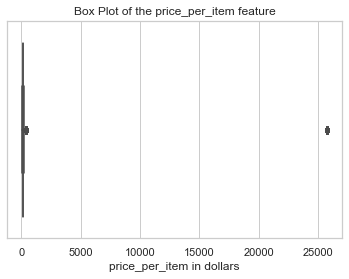

In [11]:
ax = sns.boxplot(x=df['price_per_item'])
ax.set_title("Box Plot of the price_per_item feature")
ax.set_xlabel("price_per_item in dollars")
plt.show()

**Inference**: There is a clear outlier when looking at the price_per_item for each of the shops. Note that price_per_item translates to the price at which each shop is selling a pair of sneakers for. Logically, \\$25000+ is an unreasonable price to sell a pair of sneakers for.

In [12]:
df['price_per_item'].describe()

count     5000.000000
mean       387.742800
std       2441.963725
min         90.000000
25%        133.000000
50%        153.000000
75%        169.000000
max      25725.000000
Name: price_per_item, dtype: float64

In [13]:
print(f"Average price for a pair of sneakers: ${round(df['price_per_item'].mean(),2)}")

Average price for a pair of sneakers: $387.74


In [14]:
df.groupby('shop_id').mean()['price_per_item'].reset_index().sort_values(by='price_per_item',ascending=False)[:5]

,shop_id,price_per_item
77,78,25725.0
41,42,352.0
11,12,201.0
88,89,196.0
98,99,195.0


In [15]:
print(f"Number of entries in dataset by Shop 78: {df.groupby('shop_id').count().loc[78]['price_per_item']}")

Number of entries in dataset by Shop 78: 46


**Observation**: Shop 78 is either extremely overpricing the pair of sneakers or there seems to some error on their end when entering their sneaker transaction information. It is unreasonable for a shop to on average sell a pair of sneakers for $25725 over 46 recorded transactions. 

**Action**: We will remove Shop 78's transactions from the dataset

In [16]:
df = df[df['shop_id'] != 78]

In [17]:
print(f"Average price for a pair of sneakers before removing transactions by Shop 78: ${387.74}")
print(f"Average price for a pair of sneakers after removing transactions by Shop 78: ${round(df['price_per_item'].mean(),2)}")

Average price for a pair of sneakers before removing transactions by Shop 78: $387.74
Average price for a pair of sneakers after removing transactions by Shop 78: $152.48


In [18]:
df['order_amount'].describe()

count      4954.000000
mean       2717.367784
std       41155.996469
min          90.000000
25%         163.000000
50%         284.000000
75%         390.000000
max      704000.000000
Name: order_amount, dtype: float64

Even after removing the transactions of Shop 78 from the dataset, the overall AOV is still relatively high at \\$2717.37. Now that we have established that the average price per pair of sneakers is $152.48 across all the shops excluding shop 78, we will now explore the number of sneakers sold per order. There seems to be outliers or extreme bulk orders that are significantly increasing the AOV.

#### 2. Explore the number of sneakers sold per order across the 100 stores

In [19]:
df['total_items'].value_counts().sort_values(ascending=False)

2       1816
1       1811
3        932
4        292
5         77
2000      17
6          8
8          1
Name: total_items, dtype: int64

In [20]:
df['total_items'].describe()

count    4954.000000
mean        8.851029
std       116.857286
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max      2000.000000
Name: total_items, dtype: float64

**Observation**: There are 17 transaction records or orders where 2000 pairs of sneakers have been sold. Clearly, this is swaying the AOV.

In [21]:
df[df['total_items'] == 2000]['shop_id'].unique()

array([42], dtype=int64)

It appears that Shop 42 is the only shop responsible for the 17 orders of 2000 sneakers each.

In [22]:
df[df['total_items'] == 2000]['user_id'].unique()

array([607], dtype=int64)

It appears that User 607 is the only user responsible for the 17 orders of 2000 sneakers each.

In [23]:
print(f"Number of entries in dataset by Shop 42: {df.groupby('shop_id').count().loc[42]['price_per_item']}")

Number of entries in dataset by Shop 42: 51


Shop 42 has a total of 51 orders in the dataset, of which 17 are made by User 607, and are all orders of 2000 sneakers. User 607 maybe a bulk distributor which is why each of their orders are large in quantity. We should look at the remaining 34 orders at Shop 42 to understand if there are any insights we can derive. 

In [24]:
df[(df['shop_id'] == 42) & (df['user_id'] != 607)][['order_amount','total_items','price_per_item']].describe()

,order_amount,total_items,price_per_item
count,34.000000,34.000000,34.0
mean,652.235294,1.852941,352.0
std,358.681682,1.018982,0.0
min,352.000000,1.000000,352.0
25%,352.000000,1.000000,352.0
50%,704.000000,2.000000,352.0
75%,704.000000,2.000000,352.0
max,1760.000000,5.000000,352.0


**Obersvation**: Of the remaining 34 orders at Shop 42, the average order value is \\$652.24 and the average number of items per order is 1.85. Consistently, the price per item is \\$352 across all 34 orders. 

**Action**: We can either remove only orders by User 607 or we can remove all orders at Shop 42. In order to determine which of the two actions to take, further investigation is warranted. 

In [25]:
df['price_per_item'].describe()

count    4954.000000
mean      152.475575
std        31.260218
min        90.000000
25%       132.000000
50%       153.000000
75%       168.000000
max       352.000000
Name: price_per_item, dtype: float64

The Interquartile range can be used to calculate outlier fences. Data points outside the outer fences are considered extreme outliers and data points in between the lower and upper fences are considered mild outliers

In [26]:
IQR = df['price_per_item'].describe()['75%'] - df['price_per_item'].describe()['25%']

In [27]:
lower_inner = df['price_per_item'].describe()['25%'] - (1.5*IQR)
lower_outer = df['price_per_item'].describe()['25%'] - (3*IQR)
upper_inner = df['price_per_item'].describe()['75%'] + (1.5*IQR)
upper_outer = df['price_per_item'].describe()['75%'] + (3*IQR)

In [28]:
print(f"Upper Outer Fence: {upper_outer}")
print(f"Lower Outer Fence: {lower_outer}")

Upper Outer Fence: 276.0
Lower Outer Fence: 24.0


Transactions where the price_per_item is greater than 276 or lower than 24 can be considered extreme outliers according to the aforementioned methodology.

In [29]:
df['price_per_item'].sort_values(ascending=False).unique()
# One unique price_per_item value (352) fits the extreme outlier critera and from previous 
# analysis we know it corresponds to Shop 42

array([352., 201., 196., 195., 193., 190., 187., 184., 181., 178., 177.,
       176., 173., 172., 171., 169., 168., 166., 165., 164., 163., 162.,
       161., 160., 158., 156., 155., 154., 153., 149., 148., 147., 146.,
       145., 144., 142., 140., 138., 136., 134., 133., 132., 131., 130.,
       129., 128., 127., 122., 118., 117., 116., 114., 112., 111., 101.,
        94.,  90.])

From previous analysis, we know that the price_per_item at Shop 42 is 352, meaning it can be considered as an extreme outlier. Therefore, all transactions involving Shop 42 will be dropped. 

In [30]:
df = df[df['shop_id'] != 42]

Now that all transactions involving Shop 78 and Shop 42 have been removed, lets look at some important descriptve statistics.

In [31]:
print(f"Average Order Value (AOV): ${round(df['order_amount'].mean(),2)}")
print(f"Median Order Value (MOV): ${round(df['order_amount'].median(),2)}")
print(f"Average price per pair of sneakers: ${round(df['price_per_item'].mean(),2)}")
print(f"Average number of items per order: {round(df['total_items'].mean(),3)}")

Average Order Value (AOV): $300.16
Median Order Value (MOV): $284.0
Average price per pair of sneakers: $150.4
Average number of items per order: 1.996


### b. What metric would you report for this dataset?

As previously mentioned, the mean is senstive to extreme values or outliers, and the mean is closer to the tail in a skewed distribution, which explains the initial significantly high calculated AOV. Consequently, the median is better suited for skewed distributions as it is much more robust.

Going back to the initial dataset (without dropping Shops 78 and 42), the **Median Order Value (MOV)** would be the better metric seeing that the initial dataset was heavily skewed

In [32]:
df_init['order_amount'].describe()

count      5000.000000
mean       3145.128000
std       41282.539349
min          90.000000
25%         163.000000
50%         284.000000
75%         390.000000
max      704000.000000
Name: order_amount, dtype: float64

### c. What is its value?

In [33]:
print(f"Median Order Value (MOV) of initial dataset: ${df_init['order_amount'].median()}")

Median Order Value (MOV) of initial dataset: $284.0


In [34]:
print(f"Median Order Value (MOV) of processed dataset: ${df['order_amount'].median()}")

Median Order Value (MOV) of processed dataset: $284.0


Interestingly, the Median Order Value (MOV) of the initial dataset is the same as that of the dataset where Shops 78 and 42 were removed.

In [35]:
print(f"Average Order Value (AOV) of initial dataset: ${round(df_init['order_amount'].mean(),2)}")
print(f"Average Order Value (AOV) of processed dataset: ${round(df['order_amount'].mean(),2)}")

Average Order Value (AOV) of initial dataset: $3145.13
Average Order Value (AOV) of processed dataset: $300.16


However, there is a significant difference in the AOV of the two datasets

### THE END 